In [37]:
from numba import jit, njit, config, __version__, errors
import numpy as np
import random
import matplotlib.pyplot as plt

In [38]:
@jit(nopython=True)
def vizinhos(N):
  #Define a tabela de vizinhos
  L=int(np.sqrt(N))
  viz = np.zeros((N,4),dtype=np.int16)
  for k in range(N):
    viz[k,0]=k+1
    if (k+1) % L == 0: viz[k,0] = k+1-L
    viz[k,1] = k+L
    if k > (N-L-1): viz[k,1] = k+L-N
    viz[k,2] = k-1
    if (k % L == 0): viz[k,2] = k+L-1
    viz[k,3] = k-L
    if k < L: viz[k,3] = k+N-L
  return viz

In [39]:
@jit(nopython=True)
def calcular_energia(s,viz):
  #Calcula a energia da configuração representada no array s
  N=len(s)
  ener = 0
  for i in range(N):
    h = s[viz[i,0]]+s[viz[i,1]] # soma do valor dos spins a direita e acima
    ener -= s[i]*h
  return ener

In [40]:
@jit(nopython=True)
def calcular_magnetizacao(s):
  return sum(s)

In [41]:
@jit(nopython=True)
def expos(beta):
  ex = np.zeros(5,dtype=np.float32)
  ex[0]=np.exp(8.0*beta)
  ex[1]=np.exp(4.0*beta)
  ex[2]=1.0
  ex[3]=np.exp(-4.0*beta)
  ex[4]=np.exp(-8.0*beta)
  return ex

In [42]:
def alg_metropolis(L, temp_inicial, n_passos = 1000):
  tam_rede = (L ** 2)  # Entre 24 ** 2 e 100 ** 2
  beta = 1/temp_inicial
  ex = expos(beta)
  s = [random.choice([-1, 1]) for _ in range(tam_rede)]
  viz = vizinhos(tam_rede)
  energias = np.zeros(n_passos)
  energia_atual = calcular_energia(s, viz)
  magnetizacoes = np.zeros(n_passos)
  magnetizacao_atual = calcular_magnetizacao(s)
  magnetizacao_atual = 0
  for iter in range(n_passos * tam_rede):
    i = random.randint(0, tam_rede-1)
    h = s[viz[i,0]]+s[viz[i,1]]+s[viz[i,2]]+s[viz[i,3]] # soma dos vizinhos
    de = int(s[i]*h*0.5+2)
    P = ex[de]
    r = random.uniform(0, 1)
    if (r <= P):
      energia_atual += 2 * s[i] * h
      magnetizacao_atual = magnetizacao_atual + (-1) * 2 * s[i]
      s[i] = -s[i]
    else:
      pass
    if (iter % tam_rede == 0):
      energias[int(iter/tam_rede)] = energia_atual
      magnetizacoes[int(iter/tam_rede)] = magnetizacao_atual
  return energias, magnetizacoes

In [43]:
def fazer_alg_metropolis_n_vezes(n, L, temp_inicial, n_passos = 1000):
  arr_energias = np.zeros((n,n_passos))
  arr_magnetizacoes = np.zeros((n,n_passos))
  for i in range(n):
    arr_energias[i], arr_magnetizacoes[i] = alg_metropolis(L, temp_inicial, n_passos)
  return arr_energias, arr_magnetizacoes

In [44]:
def plotar_grafo_linha(arr_dados, label_x, label_y, title = ""):
  x = range(len(arr_dados[0]))
  for y in arr_dados:
    plt.plot(x, y)

  # Add labels and a title
  plt.xlabel(label_x)
  plt.ylabel(label_y)
  plt.title(title)

  # Display the plot
  plt.show()


1) Gere uma configuração inicial para o sistema (aleatória, por exemplo).\
2) Escolha um dos spins da rede (𝑆").\
3) Determine a diferença de energia caso o spin 𝑆" fosse flipado, Δ𝐸.\
4) Calcule 𝑃 = 𝑒^(-beta * del_E), e compare com um número aleatório, 𝑟, uniformemente
distribuído no intervalo (0,1).\
    a. Se 𝑟 ≤ 𝑃, aceite a nova configuração, ou seja, flipe o spin fazendo 𝑆" =
−𝑆".\
    b. Se 𝑟 > 𝑃, mantenha o sistema na configuração em que ele se
encontrava.\
5) Volte ao passo 2.\


In [45]:
L = 32
N = L**2
temp_inicial = 1.5
beta = 1 / temp_inicial
n_passos = 1000
n = 5
arr_energias, arr_magnetizacoes = fazer_alg_metropolis_n_vezes(n, L, temp_inicial, n_passos)

/usr/local/lib/python3.10/dist-packages/numba/core/ir_utils.py:2147: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 's' of function 'calcular_energia'.

For more information visit https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "<ipython-input-39-41b5d7db27bd>", line 2:
@jit(nopython=True)
def calcular_energia(s,viz):
^

  warnings.warn(NumbaPendingDeprecationWarning(msg, loc=loc))
/usr/local/lib/python3.10/dist-packages/numba/core/ir_utils.py:2147: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 's' of function 'calcular_magnetizacao'.

For more information visit https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "<ipython-input-40-5d4296837601>", line 2:
@jit(nopy

In [46]:
print(arr_energias.shape)
print(len(arr_energias[0]))

(5, 1000)
1000


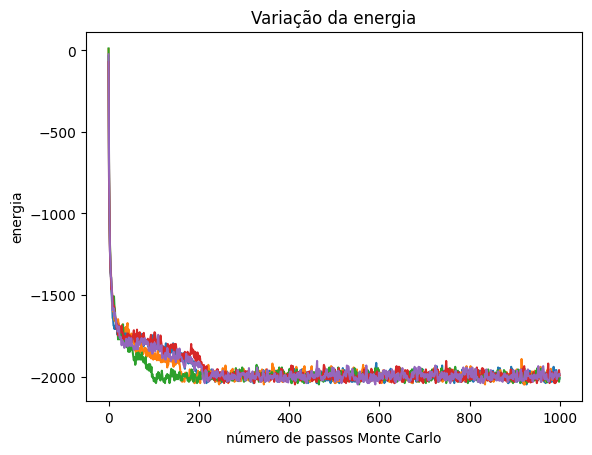

In [47]:
plotar_grafo_linha(arr_energias, "número de passos Monte Carlo", "energia", "Variação da energia")

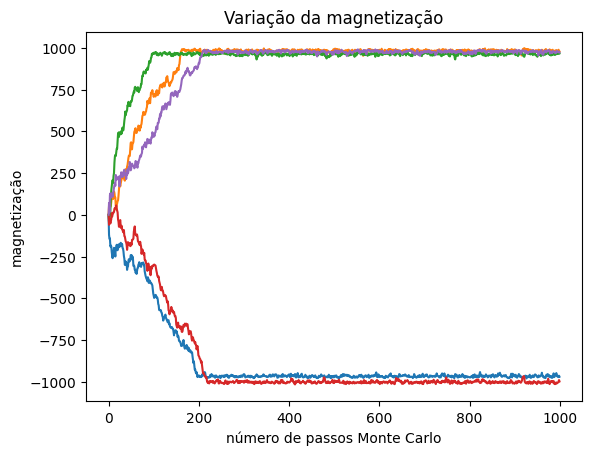

In [48]:
plotar_grafo_linha(arr_magnetizacoes, "número de passos Monte Carlo", "magnetização", "Variação da magnetização")

# PDF 2

In [49]:
# Cálculo do Calor Específico
def calc_specific_heat(arr, beta, N):
  """
  Calculates the specific_heat of a system given its energy.
  ------------
  Parameters:
    - arr (np.ndarray): array of energies of the system.
    - beta (float): constant beta.
    - N (int): number of particles in the system.
  Returns:
    - specific_heat (float): specific heat of the system.
  """
  mean_energy = np.mean(arr_energias, axis=1)
  mean_energy_squared = np.mean(arr_energias**2, axis=1)
  specific_heat = (mean_energy_squared - mean_energy**2)*(beta**2)/N
  return specific_heat

In [50]:
specific_heat = calc_specific_heat(arr_energias, beta, N)

In [51]:
# Cálculo do Erro Estatístico
from math import sqrt

def calc_stat_err(arr):
  """
  Calculates the statistical error of a measure.
  ------------
  Parameters:
    - arr (np.ndarray): array of measures from which the error will be calculated.
  Returns:
    - err (integer): the statistical error of the measure.
  """
  avg = arr.mean()
  sum = ((avg - arr)**2).sum()
  err = sqrt(sum / (len(arr) - 1))
  return err


In [52]:
calc_stat_err(specific_heat)

0.43798325701067287

In [53]:
# Cálculo da Susceptibilidade Magnética
def calc_magnet_susc(arr, beta, N):
  """
  Calculates the magnetic susceptibility of a system given its magnetization.
  ------------
  Parameters:
    - arr (np.ndarray): array of magnetizations of the system.
    - beta (float): constant beta.
    - N (int): number of particles in the system.
  Returns:
    - magnet_susc(float): magnetic susceptibility of the system.
  """
  mean_energy = np.mean(arr_energias, axis=1)
  mean_energy_squared = np.mean(arr_energias**2, axis=1)
  magnet_susc = (mean_energy_squared - mean_energy**2)*beta/N
  return magnet_susc

In [54]:
calc_magnet_susc(arr_magnetizacoes, beta, N)

array([ 9.43618317,  9.11545041,  8.26863307, 10.09399413,  9.21596999])